In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [2]:
def gaussian_function(x, y, pars=None, add_noise=False):
    if not pars:
        x0 = np.random.randn(1)[0]+0.5
        y0 = x0+0.5
        fwhm = np.random.normal(loc=1.5,scale=3, size=100).mean()
    else:
        x0, y0, fwhm = pars
        
    func = 10*np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)
    
    if add_noise:
        func = add_noise_func(func)
    
    return func, x0, y0, fwhm

def add_noise_func(input_data, mean_noise=0):
    
    avg_data = np.mean(input_data)
    noise_ = np.random.normal(mean_noise, np.sqrt(avg_data), 1)[0]
    output_data = input_data + noise_
    
    return output_data
    
def output_model(x_d1, y_d1, model=None, pars=None, cnt_point=True):

    temp_df = pd.DataFrame([(i,j) for i in x_d1 for j in y_d1], columns=['x','y'])

    if cnt_point:
        temp_df.loc[len(temp_df)] = [temp_df['x'].mean(),temp_df['y'].mean()]
        
    temp_df = normal_to_coded_var(temp_df)    
    temp_df['outcome'] = temp_df.apply(lambda x: gaussian_function(x['x'], x['y'], pars)[0], axis=1)
    
    if model:
        temp_df['predict'] = model.predict(temp_df[['x','y']])
        temp_df['mape'] = 100*(temp_df['outcome'] - temp_df['predict'])/temp_df['outcome']
        
    return temp_df

def normal_to_coded_var(temp_df, output_pars = False):
        
    mean_x = temp_df['x'].mean()
    mean_y = temp_df['y'].mean()
    range_x = temp_df['x'].max()-temp_df['x'].min()
    range_y = temp_df['y'].max()-temp_df['y'].min()
    
    temp_df['cX'] = (temp_df['x']-mean_x)/(range_x/2)
    temp_df['cY'] = (temp_df['y']-mean_y)/(range_y/2)
    
    if output_pars:
        return mean_x, mean_y, range_x, range_y
    
    return temp_df

def coded_to_normal(pars, x_coded, y_coded):
    mean_x, mean_y, range_x, range_y = pars
    
    real_x = x_coded*(range_x/2) + mean_x
    real_y = y_coded*(range_y/2) + mean_y
    
    return real_x, real_y
    
def plot_contour_fromdf(test_df, fill_value=0, model=None, levels=10, plot_normal_vars=True):
    x, y = 'cX','cY'
    
    if not model:
        hdf = test_df.groupby(input_vars).mean()
        hdfreset = hdf.reset_index()
        hdfreset.columns = [x, y, 'outcome']
        hdfpivot= hdfreset.pivot(x, y).fillna(0)

        X=hdfpivot.columns.levels[1].values
        Y=hdfpivot.index.values
        Xi,Yi = np.meshgrid(X, Y)
        Z=hdfpivot.values
    else:
        X = np.linspace(test_df[x].min(),test_df[x].max(),levels)
        Y = np.linspace(test_df[y].min(),test_df[y].max(),levels)
        Xi,Yi = np.meshgrid(X, Y)
        Z = model.predict(np.c_[Xi.ravel(),Yi.ravel()]).reshape(len(X),len(Y))
        
    if plot_normal_vars:
        temp_df = pd.DataFrame()
        temp_df[x] = Xi.ravel()
        temp_df[y] = Yi.ravel()
        Z = model.predict(temp_df).reshape(len(X),len(Y))
        mean_x, mean_y, range_x, range_y = normal_to_coded_var(test_df, output_pars = True)
        temp_df['x'] = temp_df[x]*(range_x/2) + mean_x
        temp_df['y'] = temp_df[y]*(range_y/2) + mean_y
        X = np.linspace(test_df['x'].min(),test_df['x'].max(),levels)
        Y = np.linspace(test_df['y'].min(),test_df['y'].max(),levels)
        
        Xi,Yi = np.meshgrid(X, Y)
    else:
        mean_x, mean_y = 0, 0
        
    v, u = np.gradient(Z, 0.1, 0.1)
    plt.contourf(Xi, Yi, Z, alpha=0.7)
    plt.colorbar()
    plt.quiver(Xi,Yi,u,v);

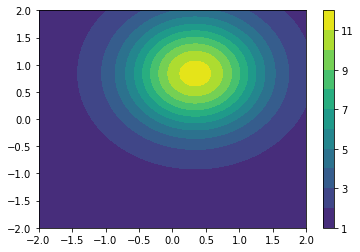

In [3]:
x = np.round(np.linspace(-2,2,101),2)
y = np.round(np.linspace(-2,2,101),2)
X, Y = np.meshgrid(x,y)
Z, x0, y0, fwhm = gaussian_function(X,Y,add_noise=True)
plt.contourf(x,y,Z, levels=10, vmin=0)
plt.colorbar()

In [4]:
def linear_pipe_fit(degree=2, interaction=True, dataframe=pd.DataFrame(), input_vars=['cX','cY']):
    
    lr = LinearRegression()
    pol = PolynomialFeatures(degree=degree, interaction_only=interaction, include_bias=False)
    pipe = Pipeline([('pol',pol), ('lr', lr)])
    pipe.fit(dataframe[input_vars], dataframe['outcome'])
    coefs = pipe['lr'].coef_
    intercept = pipe['lr'].intercept_

    return pipe

def next_step(model=None, increment_y = 1, step_x = 0.125, step_y = 0.125, dataframe=pd.DataFrame()):
    
    mean_x, mean_y, range_x, range_y = normal_to_coded_var(dataframe, output_pars = True)
    coef_x = model['lr'].coef_[0]
    coef_y = model['lr'].coef_[1]
    ratio = coef_x/coef_y
    
    print(f'coef x {coef_x:.2f} and coef y {coef_y:.2f}')
    
    increment_x = np.abs(ratio)*increment_y*np.sign(coef_x)
    increment_y = increment_y*np.sign(coef_y)
    
    print(f'increment x {increment_x:.2f} and increment y {increment_y:.2f} with ratio {ratio:.2f}')
    
    base_x = increment_x*(range_x/2)+mean_x
    base_y = increment_y*(range_y/2)+mean_y
    
    print(f'new x {base_x:.2f} and new y {base_y:.2f}')
                
    next_x = np.round(np.array([base_x-step_x, base_x+step_x]),2)
    next_y = np.round(np.array([base_y-step_y, base_y+step_y]),2)
    
    return next_x, next_y

In [5]:
# first full factorial
x_d1 = np.array([0.5,1])
y_d1 = np.array([-0.5,-1])
first_doe = output_model(x_d1, y_d1, pars=(x0, y0, fwhm), cnt_point=False)
first_doe

,x,y,cX,cY,outcome
0,0.5,-0.5,-1.0,1.0,1.712984
1,0.5,-1.0,-1.0,-1.0,0.366584
2,1.0,-0.5,1.0,1.0,1.149135
3,1.0,-1.0,1.0,-1.0,0.245918


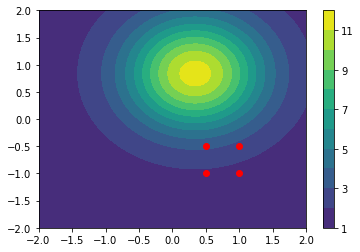

In [6]:
plt.contourf(x,y,Z, levels=10, vmin=0)
plt.colorbar()
plt.scatter(first_doe.x,first_doe.y, c='r')

In [7]:
normal_to_coded_var(first_doe, output_pars = True)

(0.75, -0.75, 0.5, 0.5)

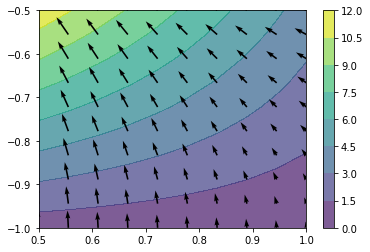

In [8]:
pipe1 = linear_pipe_fit(degree=2, interaction=True, dataframe=first_doe, input_vars=['x','y'])
plot_contour_fromdf(first_doe, fill_value=0, model = pipe1, plot_normal_vars=True)

In [9]:
x_d2, y_d2 = next_step(model=pipe1, increment_y = 2, dataframe=first_doe)
print(x_d2, y_d2)

coef x -2.01 and coef y 3.58
increment x -1.13 and increment y 2.00 with ratio -0.56
new x 0.47 and new y -0.25
[0.34 0.59] [-0.38 -0.12]


coef x -0.77 and coef y 6.47
increment x -0.24 and increment y 2.00 with ratio -0.12
new x 0.44 and new y 0.01
[0.31 0.56] [-0.12  0.14]


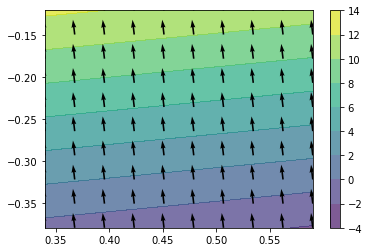

In [10]:
test_df2 = output_model(x_d2, y_d2, model = pipe1, pars=(x0, y0, fwhm), cnt_point=True)
pipe2 = linear_pipe_fit(degree=1, interaction=True, dataframe=test_df2, input_vars=['x','y'])
plot_contour_fromdf(test_df2, fill_value=0, model = pipe2)
x_d3, y_d3 = next_step(model=pipe2, increment_y = 2, dataframe=test_df2)
print(x_d3, y_d3)

In [11]:
test_df2

,x,y,cX,cY,outcome,predict,mape
0,0.340,-0.38,-1.0,-1.0,2.366292,2.250588,4.889649
1,0.340,-0.12,-1.0,1.0,4.098878,3.024462,26.212425
2,0.590,-0.38,1.0,-1.0,2.225555,1.915482,13.932384
3,0.590,-0.12,1.0,1.0,3.855094,2.574128,33.227871
4,0.465,-0.25,0.0,0.0,3.117169,2.441165,21.686456


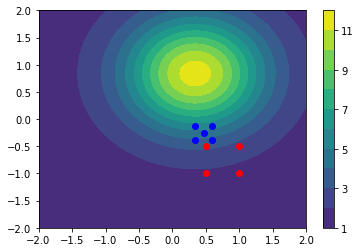

In [12]:
plt.contourf(x,y,Z, levels=10, vmin=0)
plt.colorbar()
plt.scatter(first_doe.x,first_doe.y, c='r')
plt.scatter(test_df2.x,test_df2.y, c='b')

coef x -0.94 and coef y 7.99
increment x -0.24 and increment y 2.00 with ratio -0.12
new x 0.41 and new y 0.27
[0.28 0.53] [0.15 0.4 ]


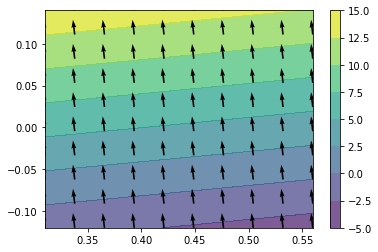

In [13]:
test_df3 = output_model(x_d3, y_d3, pipe2, pars=(x0, y0, fwhm), cnt_point=False)
pipe3 = linear_pipe_fit(degree=1, interaction=True, dataframe=test_df3, input_vars=['x','y'])
plot_contour_fromdf(test_df3, fill_value=0, model = pipe3)
x_d4, y_d4 = next_step(model=pipe3, increment_y = 2, dataframe=test_df3)
print(x_d4, y_d4)

In [14]:
test_df3

,x,y,cX,cY,outcome,predict,mape
0,0.31,-0.12,-1.0,-1.0,4.095624,4.092330,0.080434
1,0.31,0.14,-1.0,1.0,6.222036,5.773392,7.210556
2,0.56,-0.12,1.0,-1.0,3.908520,3.900070,0.216203
3,0.56,0.14,1.0,1.0,5.937789,5.581132,6.006556


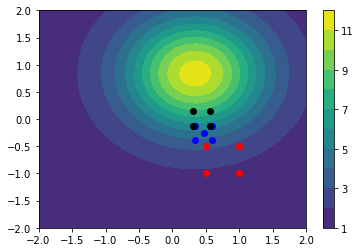

In [15]:
plt.contourf(x,y,Z, levels=10, vmin=0)
plt.colorbar()
plt.scatter(first_doe.x,first_doe.y, c='r')
plt.scatter(test_df2.x,test_df2.y, c='b')
plt.scatter(test_df3.x,test_df3.y, c='k')

coef x -0.12 and coef y 0.97
increment x -0.24 and increment y 2.00 with ratio -0.12
new x 0.38 and new y 0.53
[0.25 0.5 ] [0.4  0.65]


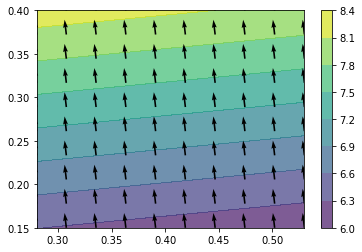

In [16]:
test_df4 = output_model(x_d4, y_d4, pipe3, pars=(x0, y0, fwhm), cnt_point=False)
pipe4 = linear_pipe_fit(degree=1, interaction=True, dataframe=test_df4, input_vars=['cX','cY'])
plot_contour_fromdf(test_df4, fill_value=0, model = pipe4)
x_d5, y_d5 = next_step(pipe4, increment_y = 2, dataframe=test_df4)
print(x_d5, y_d5)

In [17]:
test_df4

,x,y,cX,cY,outcome,predict,mape
0,0.28,0.15,-1.0,-1.0,6.290368,6.305948,-0.247674
1,0.28,0.40,-1.0,1.0,8.269079,8.303871,-0.420754
2,0.53,0.15,1.0,-1.0,6.091027,6.070272,0.340744
3,0.53,0.40,1.0,1.0,8.007033,8.068196,-0.763868


coef x -0.08 and coef y 0.67
increment x -0.12 and increment y 1.00 with ratio -0.12
new x 0.36 and new y 0.65
[0.24 0.49] [0.52 0.78]


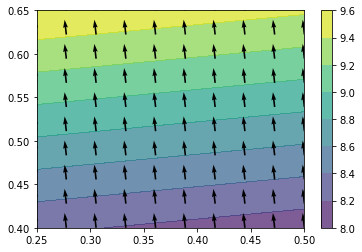

In [18]:
test_df5 = output_model(x_d5, y_d5, pipe4, pars=(x0, y0, fwhm), cnt_point=False)
pipe5 = linear_pipe_fit(degree=1, interaction=True, dataframe=test_df5, input_vars=['cX','cY'])
plot_contour_fromdf(test_df5, fill_value=0, model = pipe5)
x_d6, y_d6 = next_step(pipe5, increment_y = 1, dataframe=test_df5)
print(x_d6, y_d6)

In [19]:
test_df5

,x,y,cX,cY,outcome,predict,mape
0,0.25,0.40,-1.0,-1.0,8.233698,7.525012,8.607150
1,0.25,0.65,-1.0,1.0,9.587179,7.768431,18.970626
2,0.50,0.40,1.0,-1.0,8.089685,7.496175,7.336633
3,0.50,0.65,1.0,1.0,9.419493,7.739595,17.834276


coef x -0.06 and coef y 0.45
increment x -0.13 and increment y 1.00 with ratio -0.13
new x 0.35 and new y 0.78
[0.22 0.47] [0.66 0.9 ]


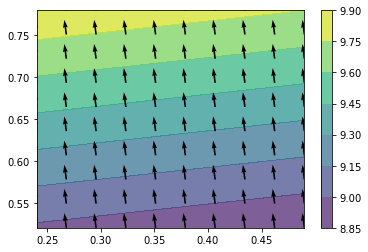

In [20]:
test_df6 = output_model(x_d6, y_d6, pipe5, pars=(x0, y0, fwhm), cnt_point=False)
pipe6 = linear_pipe_fit(degree=1, interaction=True, dataframe=test_df6, input_vars=['cX','cY'])
plot_contour_fromdf(test_df6, fill_value=0, model = pipe6)
x_d7, y_d7 = next_step(pipe6, increment_y = 1, dataframe=test_df6)
print(x_d7, y_d7)

In [21]:
test_df6

,x,y,cX,cY,outcome,predict,mape
0,0.24,0.52,-1.0,-1.0,8.976495,9.162640,-2.073694
1,0.24,0.78,-1.0,1.0,9.873025,9.337053,5.428644
2,0.49,0.52,1.0,-1.0,8.862390,9.143158,-3.168089
3,0.49,0.78,1.0,1.0,9.747524,9.317572,4.410882


In [22]:
steps_df = pd.DataFrame()
x_t = np.array([0.5,1])
y_t = np.array([-0.5,-1])

for i in range(10):
    test_df = output_model(x_t, y_t, pars=(x0, y0, fwhm), cnt_point=True)
    test_df['iteration'] = i
    pipe1 = linear_pipe_fit(degree=1, interaction=True, dataframe=test_df, input_vars=['x','y'])
    x_t, y_t = next_step(pipe1, increment_y = 2, dataframe=test_df)
    #plot_contour_fromdf(test_df, fill_value=0, model = pipe1, plot_normal_vars=True)
    steps_df = steps_df.append(test_df)
    max_outcome = test_df['outcome'].max()
    
    if max_outcome < steps_df['outcome'].max():
        print(f'maximum found at iteration {i}')
        break
    print(x_t, y_t)

coef x -0.68 and coef y 2.25
increment x -0.61 and increment y 2.00 with ratio -0.30
new x 0.60 and new y -0.25
[0.47 0.72] [-0.38 -0.12]
coef x -1.49 and coef y 6.17
increment x -0.48 and increment y 2.00 with ratio -0.24
new x 0.53 and new y 0.01
[0.41 0.66] [-0.12  0.14]
coef x -1.87 and coef y 7.77
increment x -0.48 and increment y 2.00 with ratio -0.24
new x 0.47 and new y 0.27
[0.35 0.6 ] [0.15 0.4 ]
coef x -1.87 and coef y 7.69
increment x -0.49 and increment y 2.00 with ratio -0.24
new x 0.41 and new y 0.53
[0.29 0.54] [0.4  0.65]
coef x -1.30 and coef y 5.34
increment x -0.49 and increment y 2.00 with ratio -0.24
new x 0.35 and new y 0.78
[0.23 0.48] [0.65 0.9 ]
coef x -0.31 and coef y 1.19
increment x -0.51 and increment y 2.00 with ratio -0.26
new x 0.29 and new y 1.02
[0.17 0.42] [0.9  1.15]
coef x 0.79 and coef y -3.39
increment x 0.47 and increment y -2.00 with ratio -0.23
new x 0.35 and new y 0.78
maximum found at iteration 6


<AxesSubplot:xlabel='x', ylabel='y'>

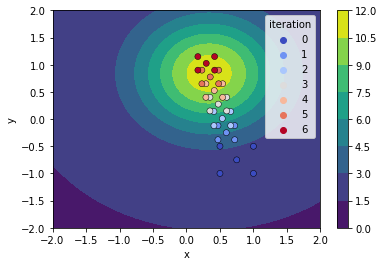

In [23]:
plt.contourf(x,y,Z)
plt.colorbar()
sns.scatterplot(x='x',y='y',data=steps_df, hue='iteration', palette='coolwarm', legend='full', edgecolor='k')

In [24]:
steps_df.head()

,x,y,cX,cY,outcome,iteration
0,0.50,-0.50,-1.0,1.0,1.712984,0
1,0.50,-1.00,-1.0,-1.0,0.366584,0
2,1.00,-0.50,1.0,1.0,1.149135,0
3,1.00,-1.00,1.0,-1.0,0.245918,0
4,0.75,-0.75,0.0,0.0,0.732752,0


In [25]:
pol = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
lr = LinearRegression()
pipe_all = Pipeline([('pol',pol), ('lr', lr)])
pipe_all.fit(steps_df[['x','y']], steps_df['outcome'])
pipe_all['lr'].coef_

array([-3.19083175,  4.7845246 ,  1.75993677,  0.95546169, -0.66164587])

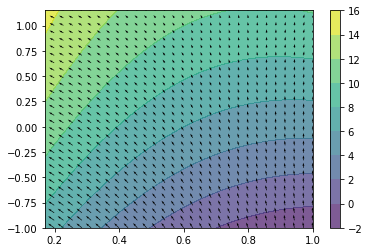

In [26]:
plot_contour_fromdf(steps_df, fill_value=0, model = pipe_all, levels=30)

In [27]:
pipe_all.score(steps_df[['x','y']], steps_df['outcome'])

0.9372121838781362

In [28]:
from sklearn.ensemble import RandomForestRegressor

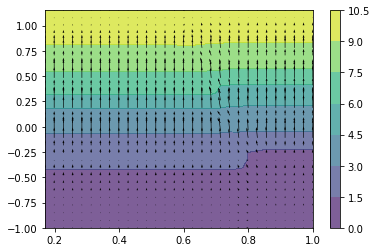

In [29]:
rfr = RandomForestRegressor(max_depth=8)
rfr.fit(steps_df[['x','y']], steps_df['outcome'])
plot_contour_fromdf(steps_df, fill_value=0, model = rfr, levels=30)